# FINAL TA: Single Label
Name : linkv12 <br>
Date : 25 November 2022<br>
Finalize the experiment for single label <br>

# Setup

In [ ]:
%%time
import tensorflow as tf
from tensorflow.keras import layers, models, losses, Model, optimizers

In [2]:
# import os for stuff
import os
import re
import copy
import string
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection  import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# to supress invalid warning 
old_err_state = np.seterr(invalid ='ignore')

In [ ]:
# nltk
import nltk
nltk.download(['stopwords','punkt'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

porterStemmer = nltk.stem.PorterStemmer()

## Constant

In [5]:
BATCHSIZE = 8
EPOCH = 100
EMBEDDING_DIM = 500

SAVE_AE = False

sep = '\\' if os.name == 'nt' else '/'
cwd = os.getcwd()

FOLDERNAME = r'{}{}data'.format(cwd, sep, sep)
TRAINNAME = r'{}{}20ng-train-all-terms.txt'.format(FOLDERNAME, sep)
TESTNAME = r'{}{}20ng-test-all-terms.txt'.format(FOLDERNAME, sep)

RESULTS = r"{}{}results{}".format(cwd, sep, sep)

In [ ]:
print(cwd)
print(FOLDERNAME)
print(TRAINNAME)
print(TESTNAME)
print(RESULTS)

## Dataset Wrangling

In [7]:
# make a single df 
train = pd.read_csv(TRAINNAME, sep='\t', header=None, names=['label', 'text'])
test = pd.read_csv(TESTNAME, sep='\t', header=None, names=['label', 'text'])

# concat
df = pd.concat([train, test], ignore_index=True)

# shuffle the DataFrame rows
shuff = df.sample(frac = 1, random_state=4473, ignore_index=True)


# label encoding
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
shuff['label_cat'] = labelencoder.fit_transform(shuff['label'])



In [8]:
# for sanity
class_name_list = list(labelencoder.classes_)
class_dict = {}

for class_name in class_name_list :
    lbl_num = labelencoder.transform([class_name])[0]
    class_dict[lbl_num] = class_name
    
print(class_dict)

{0: 'alt.atheism', 1: 'comp.graphics', 2: 'comp.os.ms-windows.misc', 3: 'comp.sys.ibm.pc.hardware', 4: 'comp.sys.mac.hardware', 5: 'comp.windows.x', 6: 'misc.forsale', 7: 'rec.autos', 8: 'rec.motorcycles', 9: 'rec.sport.baseball', 10: 'rec.sport.hockey', 11: 'sci.crypt', 12: 'sci.electronics', 13: 'sci.med', 14: 'sci.space', 15: 'soc.religion.christian', 16: 'talk.politics.guns', 17: 'talk.politics.mideast', 18: 'talk.politics.misc', 19: 'talk.religion.misc'}


In [9]:
shuff

,label,text,label_cat
0,misc.forsale,south jersey condo i have recently graduated a...,6
1,rec.sport.hockey,finland sweden vs nhl teams was helsinki stock...,10
2,talk.politics.guns,re atf burns dividian ranch update nut case pa...,16
3,rec.sport.hockey,nhl summary parse results for games played thu...,10
4,comp.graphics,help d studio ipas hi can anyone please give m...,1
...,...,...,...
18816,talk.religion.misc,re new religion forming sign up jim kasprzak k...,19
18817,rec.sport.baseball,yankee meditations do you realize that the yan...,9
18818,comp.sys.mac.hardware,re rumours about new duos bredell tdb uu se ma...,4
18819,comp.sys.ibm.pc.hardware,conner cp g info please i have a conner disk m...,3


# Preprocessing

In [10]:
%%time
def custom_standardization(input_data, verbose= False):
    # print original string
    if verbose :
        print("original string: " ,input_data)
    
    # lowering
    lowercase = input_data.lower()
    
    # print lowercase string
    if verbose :
        print('lower string: ', lowercase)
    
    
    # clean the text
    stripped = re.sub(" #39;", "\'", lowercase)
    stripped = re.sub(" quot;", "\"", stripped)
    # remove stopword
    # regex magic : r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*'
    stripped = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*',"", stripped)
    
    # print remove stopword string
    if verbose :
        print('Stopword removal: ', stripped)
    
    # strip punctuiation
    stripped = re.sub(f"[{re.escape(string.punctuation)}]", " ", stripped)
    # remove double space
    # two or more whitespace
    stripped = re.sub(r"(\s\s*)", " ", stripped)
    stripped = re.sub(r"(\s+$)", "", stripped)
    
    # tokenize
    tokens = word_tokenize(stripped)

    # print tokenize
    if verbose :
        print("toknize: ", tokens)
    
    # stemming
    temp_cont = [porterStemmer.stem(word) for word in tokens]
    
    # print stemmed
    if verbose:
        print("stemmed: ", temp_cont)
    
    porter_    = ' '.join(temp_cont)
    return porter_

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
%%time
c11_start = datetime.now()
# clean text data
clean_text = list(map(custom_standardization, shuff['text'].tolist()))
shuff['clean_text'] = clean_text

c11_duration = datetime.now() - c11_start
print("cell:map_cleaning-text \nExecution Time : {0:.2f} s".format(c11_duration.total_seconds()))

cell:map_cleaning-text 
Execution Time : 107.50 s
CPU times: total: 1min 45s
Wall time: 1min 47s


In [13]:
shuff

,label,text,label_cat,clean_text
0,misc.forsale,south jersey condo i have recently graduated a...,6,south jersey condo recent graduat look move bi...
1,rec.sport.hockey,finland sweden vs nhl teams was helsinki stock...,10,finland sweden vs nhl team helsinki stockholm ...
2,talk.politics.guns,re atf burns dividian ranch update nut case pa...,16,atf burn dividian ranch updat nut case panic r...
3,rec.sport.hockey,nhl summary parse results for games played thu...,10,nhl summari pars result game play thur april p...
4,comp.graphics,help d studio ipas hi can anyone please give m...,1,help studio ipa hi anyon pleas give ftp site g...
...,...,...,...,...
18816,talk.religion.misc,re new religion forming sign up jim kasprzak k...,19,new religion form sign jim kasprzak kasprj isa...
18817,rec.sport.baseball,yankee meditations do you realize that the yan...,9,yanke medit realiz yanke pay matt noke dollar ...
18818,comp.sys.mac.hardware,re rumours about new duos bredell tdb uu se ma...,4,rumour new duo bredel tdb uu se mat bredel wri...
18819,comp.sys.ibm.pc.hardware,conner cp g info please i have a conner disk m...,3,conner cp g info pleas conner disk model cp g ...


## Build TF-IDF SKlearn

In [14]:
%%time

c13_start = datetime.now()
# generate & fit
vectorizer = TfidfVectorizer(min_df=0.01, 
                             max_df = 0.8, 
                             ngram_range=(1, 1))
vectorizer.fit(shuff['clean_text'])
dim_size = vectorizer.get_feature_names_out().shape[0]
print("Vector Size : ", dim_size)
c13_duration = datetime.now() - c13_start
print("cell:train_tf-idf \nExecution Time : {0:.2f} s".format(c13_duration.total_seconds()))

Vector Size :  1770
cell:train_tf-idf 
Execution Time : 2.35 s
CPU times: total: 2.38 s
Wall time: 2.35 s


## K-Fold

In [15]:
K5_fold = KFold(n_splits=5)
fold = []

for train_index, test_index in K5_fold.split(shuff['clean_text']):
    val_index = test_index[int(len(test_index) / 2): ]
    test_index = test_index[:int(len(test_index)/2)]
#     print("TRAIN:", train_index, "VAL:", val_index, "TEST:", test_index)
    fold.append([train_index, val_index, test_index])

# ANN

## Build NN
Build a NN from predetermined composition <br>
Need `input_size` as a parameter          <br>


In [16]:
%time

def build_nn(input_size:int):
    input_layer = layers.Input(shape=(input_size,))

    hdn  = layers.Dense(900, activation='selu') (input_layer)
    hdn = layers.BatchNormalization(momentum=0.99, epsilon=0.0001)(hdn)
    hdn  = layers.Dense(600, activation='elu') (hdn)
    hdn = layers.BatchNormalization(momentum=0.99, epsilon=0.0001)(hdn)
    hdn  = layers.Dense(900, activation='selu') (hdn)
    hdn  = layers.Dense(700, activation='selu') (hdn)

    # using logits so this is how the output look
    predictions = layers.Dense(20, name="predictions")(hdn)
    
    model = tf.keras.Model(input_layer, predictions)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss= loss,
              optimizer="adam", 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

CPU times: total: 0 ns
Wall time: 0 ns


## Metrics for ANN

In [17]:
# function to classification_report homebrew
def _report_classification(confusion_matrix, class_name= class_dict, as_df=True) :
    # class_name -> a dict with int as key and str as value
    
    kf_tbl = {}
    for i in range(confusion_matrix.shape[0]) :
        c_name = class_name[i]
        kf_tbl[c_name] = {}
        # TP 
        kf_tbl[c_name]["TP"] = confusion_matrix[i,i]
        # FN
        # baris koma belakang
        kf_tbl[c_name]["FN"] = np.sum(confusion_matrix[i, :]) - confusion_matrix[i,i]
        # FP
        # klo liat kolom koma depan
        kf_tbl[c_name]["FP"] = np.sum(confusion_matrix[: ,i]) - confusion_matrix[i,i]
        # FN
        kf_tbl[c_name]["TN"] = np.sum(confusion_matrix) - (kf_tbl[c_name]["TP"] + kf_tbl[c_name]["FN"] + kf_tbl[c_name]["FP"])
        # Precision
        kf_tbl[c_name]["Precision"] = np.nan_to_num(kf_tbl[c_name]["TP"]/(kf_tbl[c_name]["TP"] + kf_tbl[c_name]["FP"]))

        # Recall
        kf_tbl[c_name]["Recall"] = np.nan_to_num((kf_tbl[c_name]["TP"]/(kf_tbl[c_name]["TP"] + kf_tbl[c_name]["FN"])))
        # f1-score per-class
        _temp = (kf_tbl[c_name]["Precision"]* kf_tbl[c_name]["Recall"])
        _temp = _temp/(kf_tbl[c_name]["Precision"] + kf_tbl[c_name]["Recall"])
        _temp = np.nan_to_num(_temp)
        kf_tbl[c_name]["f1-score"] = np.nan_to_num(2*_temp)
    if as_df : 
        t_tbl = {"labels" : [],
                 "TP"     : [],
                 "FN"     : [],
                 "FP"     : [],
                 "TN"     : [],
                 "Precision" : [],
                 "Recall"    : [],
                 "f1-score"  : []
                }
        for key in list(kf_tbl.keys()) :
            t_tbl['labels'].append(key)
            t_tbl['TP'].append(kf_tbl[key]['TP'])
            t_tbl['FN'].append(kf_tbl[key]['FN'])
            t_tbl['FP'].append(kf_tbl[key]['FP'])
            t_tbl['TN'].append(kf_tbl[key]['TN'])
            t_tbl['Precision'].append(kf_tbl[key]['Precision'])
            t_tbl['Recall'].append(kf_tbl[key]['Recall'])
            t_tbl['f1-score'].append(kf_tbl[key]['f1-score'])
        df = pd.DataFrame.from_dict(t_tbl)
        df = df.set_index('labels')
        
        return df
    
    return kf_tbl

In [18]:
# function to convert data from _report_classification to macro-f1 and micro-f1 and weighted-f1
# support = tp + fn
def get_f1(cls_report) :
    cls_report_type = type(cls_report)
    if cls_report_type is dict :
        cls_num = len(list(cls_report.keys()))
        cls_keys = list(cls_report.keys())
        
        # macro
        # get all f1-score then just average it to cls_num
        _f1_list = []
        for key in cls_keys :
            _f1_list.append(cls_report[key]['f1-score'])
        _macro_f1 = sum(_f1_list) / cls_num
        _f1_list = None
        
        # weigthed
        # support_proportion = support / sum(support)
        # sum(f1*support_proportion)
        _f1_list = []
        _sum_support = 0
        for key in cls_keys :
            _support = cls_report[key]['TP'] + cls_report[key]['FN']
            _f1_list.append(cls_report[key]['f1-score'] * _support)
            _sum_support += _support
        _weighted_f1 = sum(_f1_list) / _sum_support
        _f1_list = None
                        
        # micro
        # all_class_TP FP  amnd FN
        # using that just count f1 normally
        _sum_TP = 0
        _sum_FP = 0
        _sum_FN = 0
        for key in cls_keys :
            _sum_TP += cls_report[key]['TP']
            _sum_FP += cls_report[key]['FP']
            _sum_FN += cls_report[key]['FN']
        _micro_f1 = _sum_TP / (_sum_TP + (0.5*(_sum_FP + _sum_FN)))
                        
        rslt = {'f1' : {
                'micro'    : _micro_f1,
                'macro'    : _macro_f1,
                'weighted' : _weighted_f1}
              }
        return rslt
    elif cls_report_type is pd.core.frame.DataFrame :
        cls_num = cls_report.shape[0]
        
        # macro
        _macro_f1 = sum(cls_report['f1-score'].tolist()) / len(cls_report['f1-score'].tolist())
        
        # weighted
        # support = tp + fn
        _cls_TP = cls_report['TP'].tolist()
        _cls_FN = cls_report['FN'].tolist()
        _cls_f1 = cls_report['f1-score'].tolist()
        
        _support = [_cls_TP[i] + _cls_FN[i] for i in range(len(_cls_TP))]
        _sum_support = sum(_support)
        
        # sum(f1[i] * (support[i] / sum(support)))
        _weighted_f1 = sum([_cls_f1[i] * (_support[i] / _sum_support) for i in range(len(_cls_f1))])
        
        # micro
        _sum_TP = sum(cls_report['TP'].tolist())
        _sum_FP = sum(cls_report['FP'].tolist())
        _sum_FN = sum(cls_report['FN'].tolist())
        _micro_f1 = _sum_TP / (_sum_TP + (0.5*(_sum_FP + _sum_FN)))
        
        rslt = {'f1' : {
                'micro'    : _micro_f1,
                'macro'    : _macro_f1,
                'weighted' : _weighted_f1}
              }
        return rslt
    else :
        err = {'f1' : {
                'micro'    : -4473,
                'macro'    : -4473,
                'weighted' : -4473}
              }
        
        return err

In [19]:
def _average_dataframe(list_dframe: list) :
    for i in range(len(list_dframe)) :
        if i == 0 :
            f_avg = list_dframe[i]
        else :
            f_avg = f_avg.add(list_dframe[i])

    # divide by amount of fold
    f_avg = f_avg.div(len(list_dframe))

    # round down
    f_avg['TP'] = f_avg['TP'].astype('int')
    f_avg['FN'] = f_avg['FN'].astype('int')
    f_avg['FP'] = f_avg['FP'].astype('int')
    f_avg['TN'] = f_avg['TN'].astype('int')
    
    # return an average of all dataframe
    return f_avg

# Evaluation

Evaluate the f1-measure and acc

## Function to Evaluate Vanilla Performance

In [20]:
def _eval_control(save_file=False) :

    i = 1
    t_res = []
    t_loss = []
    t_acc =[]
    
    list_dataframe = []
    for train_index, val_index, test_index in fold :
        f_cstart = datetime.now()
        # clear session _del model from memory
        tf.keras.backend.clear_session()
    
        X_train = vectorizer.transform(shuff['clean_text'][train_index]).toarray()
        X_val = vectorizer.transform(shuff['clean_text'][val_index]).toarray()
        X_test = vectorizer.transform(shuff['clean_text'][test_index]).toarray()
        
        
        y_train = shuff['label_cat'][train_index]
        y_val = shuff['label_cat'][val_index]
        y_test = shuff['label_cat'][test_index]
        
        nn_name = "single_control_{}".format(i)
        nn_model = build_nn(input_size=dim_size)
        nn_model._name = nn_name
        
        # train - fit
        fit_history = nn_model.fit(X_train, 
                                    y_train, 
                                    epochs=100, 
                                    batch_size=75, 
                                    validation_data = (X_val, y_val),
                                    verbose=0)
        # eval
        # print("Evaluate on test data ", i)
        results = nn_model.evaluate(X_test, y_test, batch_size=128, verbose=0)
        # print(nn_model.metrics_names)
        print("test loss, test acc:", results)
        pred = nn_model.predict(X_test, verbose=0)
        pred = np.argmax(pred, axis=1)
        result_df = _report_classification(confusion_matrix(y_test, pred))
        result_f1 = get_f1(result_df)
        print("fold {} f1-macro : {}".format(i, result_f1['f1']['macro']))
        t_res.append(result_f1['f1']['macro'])
        t_loss.append(results[0])
        t_acc.append(results[1])
        
        list_dataframe.append(result_df)
                
        # delete
        X_train, X_val,X_test = None, None, None
        y_train, y_val,y_test = None, None, None
        
        f_cdur = datetime.now() - f_cstart
        print("func:eval_model on fold {} \nExecution Time : {:.2f} s".format(i , f_cdur.total_seconds()))
        print()
                
        i += 1
        
    result_avg = _average_dataframe(list_dataframe)
    
    d_result = {'result' : result_avg,
                'f1-macro' : sum(t_res) / len(t_res),
                'loss' : sum(t_loss) / len(t_loss),
                'acc'  : sum(t_acc) / len(t_acc)}
    
    print('control result')
    print(d_result)
    return d_result

### Control Experiment Result

In [21]:
control_measurement = _eval_control(save_file=True)

test loss, test acc: [4.706718921661377, 0.7832093238830566]
fold 1 f1-macro : 0.7812837417444415
func:eval_model on fold 1 
Execution Time : 190.65 s

test loss, test acc: [4.474344253540039, 0.8023379445075989]
fold 2 f1-macro : 0.7932568378629329
func:eval_model on fold 2 
Execution Time : 192.41 s

test loss, test acc: [4.659121990203857, 0.7901169061660767]
fold 3 f1-macro : 0.787102566283397
func:eval_model on fold 3 
Execution Time : 193.35 s

test loss, test acc: [4.537060737609863, 0.8028692603111267]
fold 4 f1-macro : 0.7973111734293381
func:eval_model on fold 4 
Execution Time : 192.41 s

test loss, test acc: [4.939093112945557, 0.7789585590362549]
fold 5 f1-macro : 0.7806415261327415
func:eval_model on fold 5 
Execution Time : 190.18 s

control result
{'result':                           TP  FN  FP    TN  Precision    Recall  f1-score
labels                                                                   
alt.atheism               59  23  14  1784   0.805655  0.714955  0.

In [22]:
print(control_measurement)
print("AVERAGE PRECISION : ", control_measurement['result']['Precision'].mean())
print("AVERAGE RECALL : ", control_measurement['result']['Recall'].mean())

{'result':                           TP  FN  FP    TN  Precision    Recall  f1-score
labels                                                                   
alt.atheism               59  23  14  1784   0.805655  0.714955  0.757487
comp.graphics             61  34  22  1763   0.756770  0.639373  0.683287
comp.os.ms-windows.misc   72  20  35  1753   0.675101  0.778939  0.720929
comp.sys.ibm.pc.hardware  60  35  27  1759   0.686697  0.633072  0.657229
comp.sys.mac.hardware     68  27  20  1765   0.769418  0.713479  0.738496
comp.windows.x            74  23  22  1761   0.782917  0.758401  0.763682
misc.forsale              78  23  23  1757   0.770937  0.771459  0.770051
rec.autos                 83  18  26  1753   0.780279  0.817838  0.790888
rec.motorcycles           88  13  13  1767   0.880750  0.869075  0.872416
rec.sport.baseball        88  15  12  1765   0.878775  0.852300  0.864247
rec.sport.hockey          85  10   6  1779   0.935593  0.887871  0.909794
sci.crypt                 8

## Function to Compare with other alg

In [24]:
# train_index, val_index, test_index = fold[0]

# X_train = vectorizer.transform(shuff['clean_text'][train_index]).toarray()
# X_val = vectorizer.transform(shuff['clean_text'][val_index]).toarray()
# X_test = vectorizer.transform(shuff['clean_text'][test_index]).toarray()
        
        
# y_train = shuff['label_cat'][train_index]
# y_val = shuff['label_cat'][val_index]
# y_test = shuff['label_cat'][test_index]

In [26]:
def _eval_svm(save_file=False) :
    i = 1
    t_res = []
    list_dataframe = []
    for train_index, val_index, test_index in fold :
        f_svmstart = datetime.now()
        
        
        X_train = vectorizer.transform(shuff['clean_text'][train_index]).toarray()
        X_val = vectorizer.transform(shuff['clean_text'][val_index]).toarray()
        X_test = vectorizer.transform(shuff['clean_text'][test_index]).toarray()


        y_train = shuff['label_cat'][train_index].tolist()
        y_val = shuff['label_cat'][val_index].tolist()
        y_test = shuff['label_cat'][test_index].tolist()
        
        svc = svm.SVC(kernel='linear',decision_function_shape='ovr')
        svc.fit(X_train, y_train)
    
        pred = svc.predict(X_test)
        
        result_df = _report_classification(confusion_matrix(y_test, pred))
        
        list_dataframe.append(result_df)
        # delete
        X_train, X_val,X_test = None, None, None
        y_train, y_val,y_test = None, None, None
        
        print('finish fold-{}'.format(i))
        i += 1
    # average all fold
    result_avg = _average_dataframe(list_dataframe)
    result_f1 = get_f1(result_avg)

    f_svmduration = datetime.now() - f_svmstart
    print("func:evaluate_svm \nExecution Time : {:2f} s".format(f_svmduration.total_seconds()))
    return {'result' : result_avg,
            'f1'     : result_f1}
    
    

In [27]:
svm_result = _eval_svm(save_file=False)
print(svm_result)

print("AVERAGE PRECISION : ", svm_result['result']['Precision'].mean())
print("AVERAGE RECALL : ", svm_result['result']['Recall'].mean())

finish fold-1
finish fold-2
finish fold-3
finish fold-4
finish fold-5
func:evaluate_svm 
Execution Time : 141.400921 s
{'result':                           TP  FN  FP    TN  Precision    Recall  f1-score
labels                                                                   
alt.atheism               64  19  17  1780   0.783406  0.776026  0.778089
comp.graphics             71  24  33  1752   0.681318  0.748135  0.712850
comp.os.ms-windows.misc   74  18  24  1764   0.752914  0.798481  0.773266
comp.sys.ibm.pc.hardware  68  26  26  1760   0.726618  0.719975  0.721719
comp.sys.mac.hardware     72  23  20  1765   0.778855  0.754693  0.765311
comp.windows.x            76  22  17  1766   0.812517  0.770331  0.789705
misc.forsale              84  16  20  1760   0.805960  0.835878  0.820072
rec.autos                 90  11  17  1762   0.841711  0.884487  0.861894
rec.motorcycles           91   9   5  1775   0.945692  0.903962  0.923115
rec.sport.baseball        94  10  10  1767   0.898678  0

In [28]:
def _eval_nb(save_file=False) :
    i = 1
    t_res = []
    list_dataframe = []
    for train_index, val_index, test_index in fold :
        f_nbstart = datetime.now()
        
        
        X_train = vectorizer.transform(shuff['clean_text'][train_index]).toarray()
        X_val = vectorizer.transform(shuff['clean_text'][val_index]).toarray()
        X_test = vectorizer.transform(shuff['clean_text'][test_index]).toarray()


        y_train = shuff['label_cat'][train_index]
        y_val = shuff['label_cat'][val_index]
        y_test = shuff['label_cat'][test_index]
        
        mb_nb = MultinomialNB(alpha = 0.6)
        mb_nb.fit(X_train, y_train)
    
        pred = mb_nb.predict(X_test)
        
        result_df = _report_classification(confusion_matrix(y_test, pred))
        
        list_dataframe.append(result_df)
        # delete
        X_train, X_val,X_test = None, None, None
        y_train, y_val,y_test = None, None, None
        
        print('finish fold-{}'.format(i))
        i += 1
    # average all fold
    result_avg = _average_dataframe(list_dataframe)
    result_f1 = get_f1(result_avg)

    f_nbduration = datetime.now() - f_nbstart
    print("func:evaluate_naivebayes \nExecution Time : {:2f} s".format(f_nbduration.total_seconds()))
    return {'result' : result_avg,
            'f1'     : result_f1}
    
    

In [29]:
nb_result = _eval_nb()
print(nb_result)
print("AVERAGE PRECISION : ", nb_result['result']['Precision'].mean())
print("AVERAGE RECALL : ", nb_result['result']['Recall'].mean())

finish fold-1
finish fold-2
finish fold-3
finish fold-4
finish fold-5
func:evaluate_naivebayes 
Execution Time : 2.619381 s
{'result':                           TP  FN  FP    TN  Precision    Recall  f1-score
labels                                                                   
alt.atheism               61  21  22  1776   0.730118  0.741209  0.734093
comp.graphics             69  26  40  1745   0.632474  0.728996  0.676367
comp.os.ms-windows.misc   69  23  29  1759   0.702695  0.743585  0.721466
comp.sys.ibm.pc.hardware  65  29  33  1753   0.665525  0.688949  0.676296
comp.sys.mac.hardware     67  28  20  1766   0.768721  0.701948  0.732761
comp.windows.x            78  20  23  1760   0.772777  0.793926  0.782180
misc.forsale              78  23  14  1766   0.842735  0.775580  0.806514
rec.autos                 87  15  18  1761   0.826592  0.853957  0.839137
rec.motorcycles           90  10  14  1766   0.867775  0.894806  0.879900
rec.sport.baseball        91  12   9  1768   0.9064

## Analisis Dataset

In [30]:
print("Jumlah baris pada dataset")
shuff.describe().loc['count']

Jumlah baris pada dataset


label_cat    18821.0
Name: count, dtype: float64

In [31]:
# Distribusi dan jumlah tiap kategori
# shuff['label'].tolist()
class_dict

count_dict = {}
for key, item in class_dict.items() :
    count_dict[item] = shuff['label'].tolist().count(item)
    
# count_dict

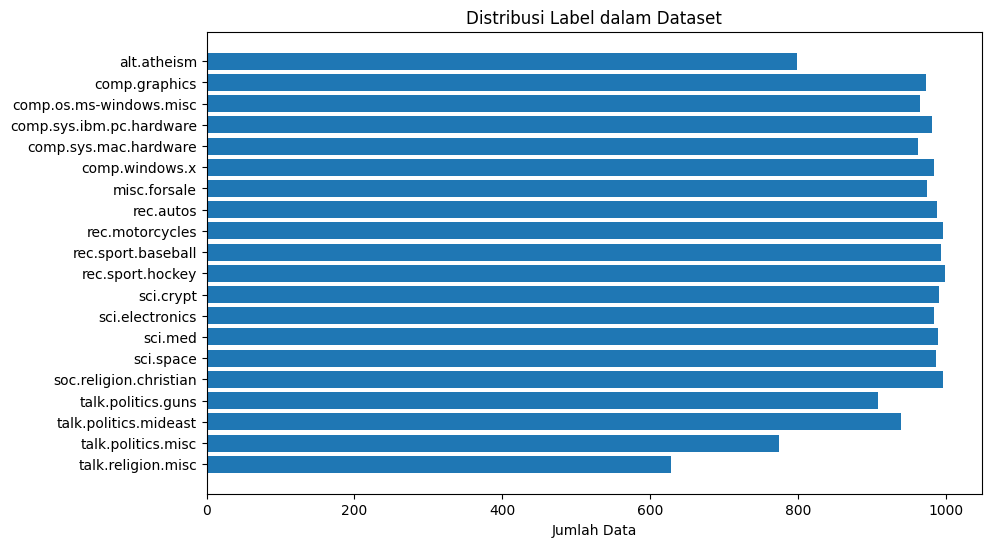

In [32]:

_i = plt.ioff()

label = list(count_dict.keys())
count = list(count_dict.values())

fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
 

ax1.barh(label, count, align='center')
ax1.set_yticks(label, labels=label)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Jumlah Data')
ax1.set_title('Distribusi Label dalam Dataset')

plt.show()

# fig.savefig("./results/img/single_label_distribution.png")
# close all fig after printed
plt.close('all')
_i = plt.ion()